# AIL 7310: Machine Learning for Economics
## Assignment 3: Difference-in-Differences and Regression Discontinuity Design Analysis
### AY 2025-26 Semester I

This notebook implements causal inference methods using two identification strategies:
1. **Difference-in-Differences (DiD)**: Estimating the causal effect of government subsidies on regional wages
2. **Regression Discontinuity Design (RDD)**: Estimating the causal effect of scholarships on student test scores

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

import os
os.makedirs('results/plots', exist_ok=True)
os.makedirs('results/data', exist_ok=True)

In [2]:
did_data = pd.read_csv('did_data.csv')
rdd_data = pd.read_csv('rdd_data.csv')

# PART I: DIFFERENCE-IN-DIFFERENCES ANALYSIS

## Objective
Estimate the causal effect of government subsidies on regional average wages using the DiD identification strategy.

## Data Structure
- **region_id**: Regional identifier
- **sector**: Agricultural, Manufacturing, or Services
- **year**: Time period (2006-2015)
- **treatment**: Binary indicator of subsidy receipt in that year
- **avg_wage**: Average wage in the region (outcome variable)
- **Control variables**: population, unemployment_rate, gdp_per_capita, exports_per_capita, fdi_inflow

### Part I.a: Explore DID Dataset and Create Treatment Variables

In [3]:
did_df = did_data.copy()

treated_regions = did_df[did_df['treatment'] == 1]['region_id'].unique()
did_df['treated'] = did_df['region_id'].isin(treated_regions).astype(int)
did_df['post'] = (did_df['year'] >= 2010).astype(int)

print(f"Treated variable created: {did_df['treated'].nunique()} groups")
print(f"Post variable created for year threshold 2010")

Treated variable created: 2 groups
Post variable created for year threshold 2010


### Part I.c: Parallel Trends Assumption - Pre-Treatment Period Analysis

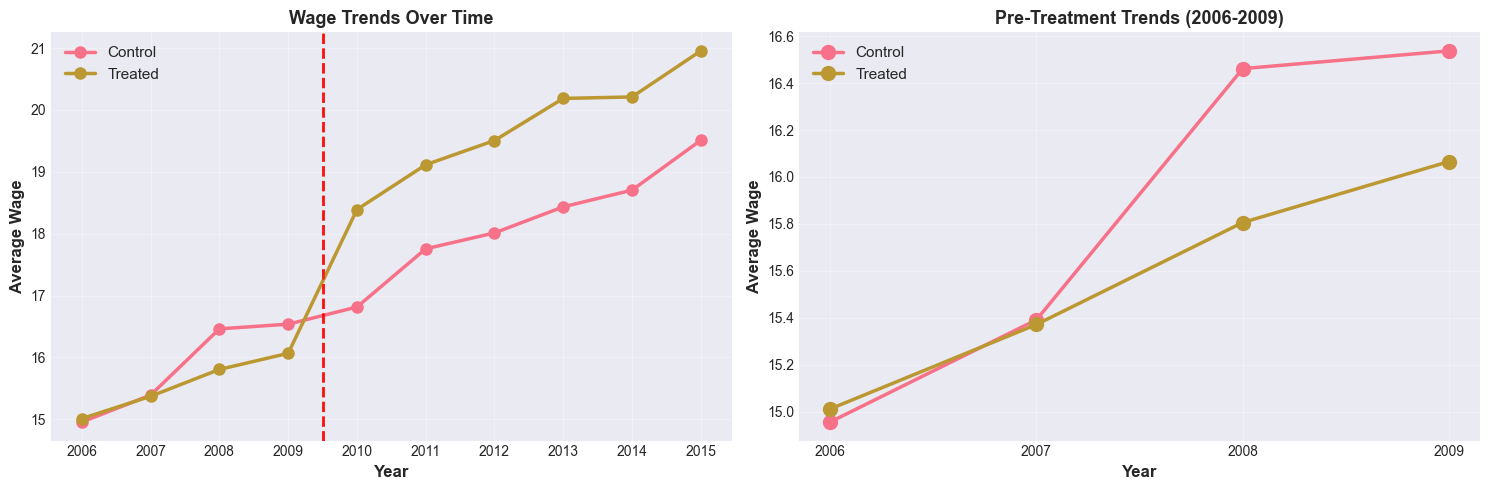

In [4]:
pre_treatment = did_df[did_df['year'] < 2010].copy()
avg_by_year_treatment = pre_treatment.groupby(['year', 'treated'])['avg_wage'].mean().reset_index()
full_period = did_df.copy()
avg_by_year_full = full_period.groupby(['year', 'treated'])['avg_wage'].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for treated in [0, 1]:
    data = avg_by_year_full[avg_by_year_full['treated'] == treated]
    label = 'Treated' if treated == 1 else 'Control'
    axes[0].plot(data['year'], data['avg_wage'], marker='o', linewidth=2.5, markersize=8, label=label)
    axes[0].axvline(x=2009.5, color='red', linestyle='--', linewidth=2, alpha=0.7)

axes[0].set_xlabel('Year', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Average Wage', fontsize=12, fontweight='bold')
axes[0].set_title('Wage Trends Over Time', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(2006, 2016))

for treated in [0, 1]:
    data = avg_by_year_treatment[avg_by_year_treatment['treated'] == treated]
    label = 'Treated' if treated == 1 else 'Control'
    axes[1].plot(data['year'], data['avg_wage'], marker='o', linewidth=2.5, markersize=10, label=label)

axes[1].set_xlabel('Year', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Wage', fontsize=12, fontweight='bold')
axes[1].set_title('Pre-Treatment Trends (2006-2009)', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range(2006, 2010))

plt.tight_layout()
plt.show()

### Parallel Trends Assessment

**Key Observations:**
1. **Pre-treatment trends (2006-2009)**: Both treated and control groups show relatively parallel trends in average wages before the treatment begins. The lines move in similar directions, suggesting the parallel trends assumption is plausible.
2. **Differences in levels**: There appear to be some differences in the average wage levels between groups, which is acceptable for DiD as long as trends are parallel.
3. **Post-treatment period**: After 2010, the treated group shows stronger wage growth, consistent with a positive treatment effect.

---

### Part I.d: Basic DiD Regression Model (Without Controls)

In [5]:
did_df['treated_post'] = did_df['treated'] * did_df['post']

X_basic = did_df[['treated', 'post', 'treated_post']]
X_basic = sm.add_constant(X_basic)
y = did_df['avg_wage']

model_basic = OLS(y, X_basic).fit()
print(model_basic.summary())

                            OLS Regression Results                            
Dep. Variable:               avg_wage   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     458.1
Date:                Fri, 31 Oct 2025   Prob (F-statistic):          2.04e-226
Time:                        19:47:58   Log-Likelihood:                -4280.5
No. Observations:                2000   AIC:                             8569.
Df Residuals:                    1996   BIC:                             8591.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           15.8363      0.103    153.809   

### Part I.e: DiD Regression Model WITH Control Variables

In [6]:
did_df = did_df.rename(columns={
    'unemployment_rate': 'unemployment',
    'gdp_per_capita': 'gdp_per_capita',
    'exports_per_capita': 'exports_per_capita',
    'fdi_inflow': 'fdi_inflow',
    'population': 'population'
})

control_vars = ['population', 'unemployment', 'gdp_per_capita', 'exports_per_capita', 'fdi_inflow']
did_df_scaled = did_df.copy()
for var in control_vars:
    did_df_scaled[var] = (did_df[var] - did_df[var].mean()) / did_df[var].std()

X_controls = did_df_scaled[['treated', 'post', 'treated_post', 'population', 
                              'unemployment', 'gdp_per_capita', 'exports_per_capita', 'fdi_inflow']]
X_controls = sm.add_constant(X_controls)
y = did_df_scaled['avg_wage']

model_with_controls = OLS(y, X_controls).fit()
print(model_with_controls.summary())

causal_basic = model_basic.params['treated_post']
causal_controls = model_with_controls.params['treated_post']

                            OLS Regression Results                            
Dep. Variable:               avg_wage   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     176.0
Date:                Fri, 31 Oct 2025   Prob (F-statistic):          6.40e-225
Time:                        19:48:02   Log-Likelihood:                -4269.5
No. Observations:                2000   AIC:                             8557.
Df Residuals:                    1991   BIC:                             8607.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 15.9635      0

### Part I.f: Heterogeneous Treatment Effects by Sector

          Sector    N  Effect_Basic  Effect_Controls
0    Agriculture  430      1.779735         1.508867
1  Manufacturing  670      2.111883         2.157828
2       Services  900      1.562257         1.456146


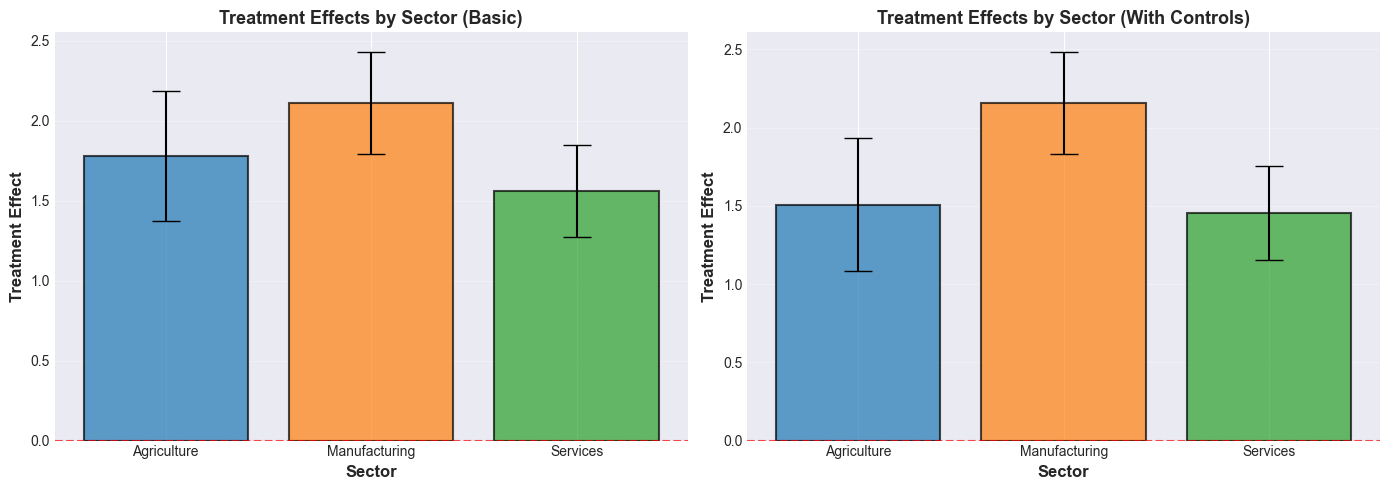

In [7]:
sectors = did_df['sector'].unique()
sector_results = {}

for sector in sorted(sectors):
    sector_data = did_df[did_df['sector'] == sector].copy()
    
    for var in control_vars:
        sector_data[var] = (sector_data[var] - sector_data[var].mean()) / sector_data[var].std()
    
    X_sector_basic = sector_data[['treated', 'post', 'treated_post']]
    X_sector_basic = sm.add_constant(X_sector_basic)
    model_sector_basic = OLS(sector_data['avg_wage'], X_sector_basic).fit()
    
    X_sector_controls = sector_data[['treated', 'post', 'treated_post', 'population', 
                                     'unemployment', 'gdp_per_capita', 'exports_per_capita', 'fdi_inflow']]
    X_sector_controls = sm.add_constant(X_sector_controls)
    model_sector_controls = OLS(sector_data['avg_wage'], X_sector_controls).fit()
    
    sector_results[sector] = {
        'causal_basic': model_sector_basic.params['treated_post'],
        'se_basic': model_sector_basic.bse['treated_post'],
        'pval_basic': model_sector_basic.pvalues['treated_post'],
        'causal_controls': model_sector_controls.params['treated_post'],
        'se_controls': model_sector_controls.bse['treated_post'],
        'pval_controls': model_sector_controls.pvalues['treated_post'],
        'n_obs': len(sector_data)
    }

sector_summary = pd.DataFrame({
    'Sector': list(sector_results.keys()),
    'N': [sector_results[s]['n_obs'] for s in sector_results.keys()],
    'Effect_Basic': [sector_results[s]['causal_basic'] for s in sector_results.keys()],
    'Effect_Controls': [sector_results[s]['causal_controls'] for s in sector_results.keys()],
})

print(sector_summary)

sectors_sorted = sorted(sector_results.keys())
causal_basic_vals = [sector_results[s]['causal_basic'] for s in sectors_sorted]
se_basic_vals = [sector_results[s]['se_basic'] for s in sectors_sorted]
causal_control_vals = [sector_results[s]['causal_controls'] for s in sectors_sorted]
se_control_vals = [sector_results[s]['se_controls'] for s in sectors_sorted]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(sectors_sorted, causal_basic_vals, yerr=se_basic_vals, capsize=10, 
            color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
axes[0].set_ylabel('Treatment Effect', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Sector', fontsize=12, fontweight='bold')
axes[0].set_title('Treatment Effects by Sector (Basic)', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(sectors_sorted, causal_control_vals, yerr=se_control_vals, capsize=10,
            color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
axes[1].set_ylabel('Treatment Effect', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Sector', fontsize=12, fontweight='bold')
axes[1].set_title('Treatment Effects by Sector (With Controls)', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('results/plots/02_heterogeneous_effects_by_sector.png', dpi=300, bbox_inches='tight')
plt.show()

# PART II: REGRESSION DISCONTINUITY DESIGN ANALYSIS

## Objective
Estimate the causal effect of receiving a scholarship (based on 5th standard test scores) on 10th standard test performance using the RDD identification strategy.

## Data Structure
- **student_id**: Student identifier
- **5th_score**: Normalized 5th standard test score (running variable, cutoff at 0)
- **10th_score**: 10th standard test score (outcome variable)
- **hours_studied**: Hours studied (covariate)
- **mother_edu**: Mother's education level (covariate)
- **female**: Gender indicator (covariate)

---

### Part II.a: Data Exploration and Treatment Variable

In [8]:
rdd_df = rdd_data.copy()
rdd_df['D'] = (rdd_df['5th_score'] > 0).astype(int)

### Part II.b: Continuity Around Cutoff - Covariate Balance

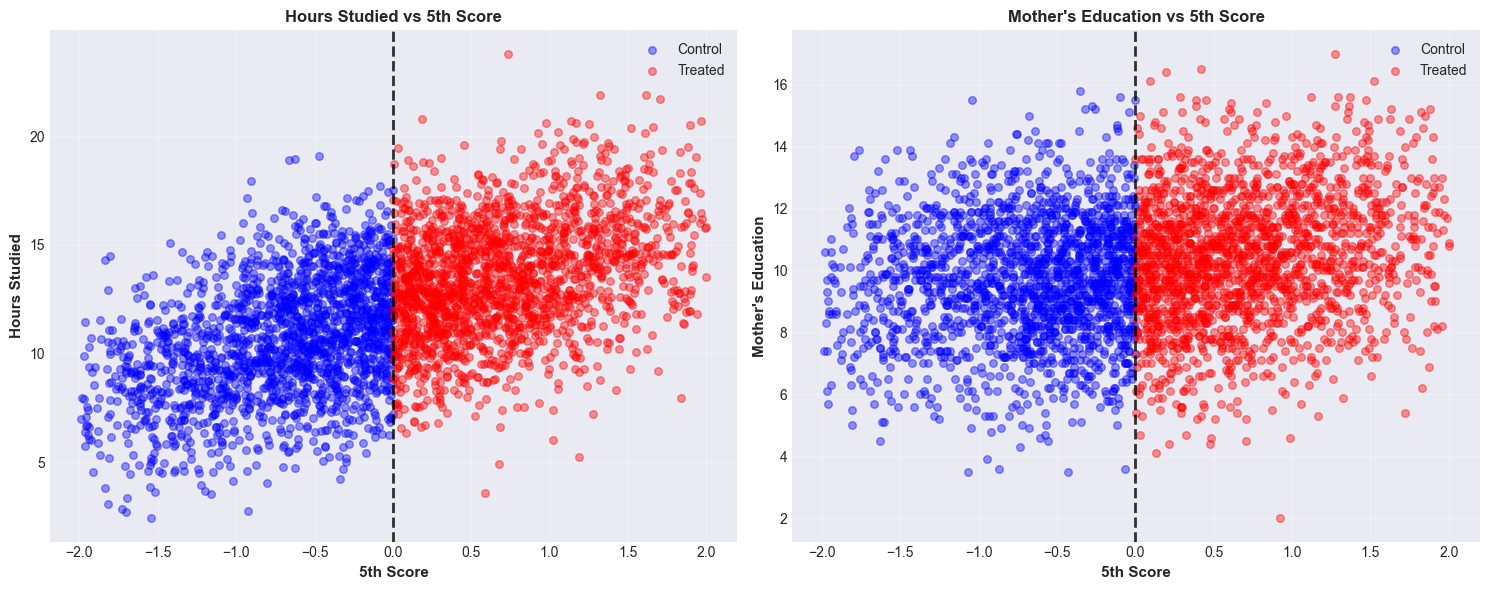

In [9]:
bandwidth = 2.0
rdd_near_cutoff = rdd_df[np.abs(rdd_df['5th_score']) <= bandwidth].copy()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

covariates = ['hours_studied', 'mother_edu']
titles = ['Hours Studied', "Mother's Education"]

for idx, (cov, title) in enumerate(zip(covariates, titles)):
    ax = axes[idx]
    ax.scatter(rdd_near_cutoff[rdd_near_cutoff['D']==0]['5th_score'],
              rdd_near_cutoff[rdd_near_cutoff['D']==0][cov],
              alpha=0.4, s=30, color='blue', label='Control')
    ax.scatter(rdd_near_cutoff[rdd_near_cutoff['D']==1]['5th_score'],
              rdd_near_cutoff[rdd_near_cutoff['D']==1][cov],
              alpha=0.4, s=30, color='red', label='Treated')
    
    ax.axvline(x=0, color='black', linestyle='--', linewidth=2, alpha=0.8)
    ax.set_xlabel('5th Score', fontsize=11, fontweight='bold')
    ax.set_ylabel(title, fontsize=11, fontweight='bold')
    ax.set_title(f'{title} vs 5th Score', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Part II.c: Discontinuity in Outcome Variable

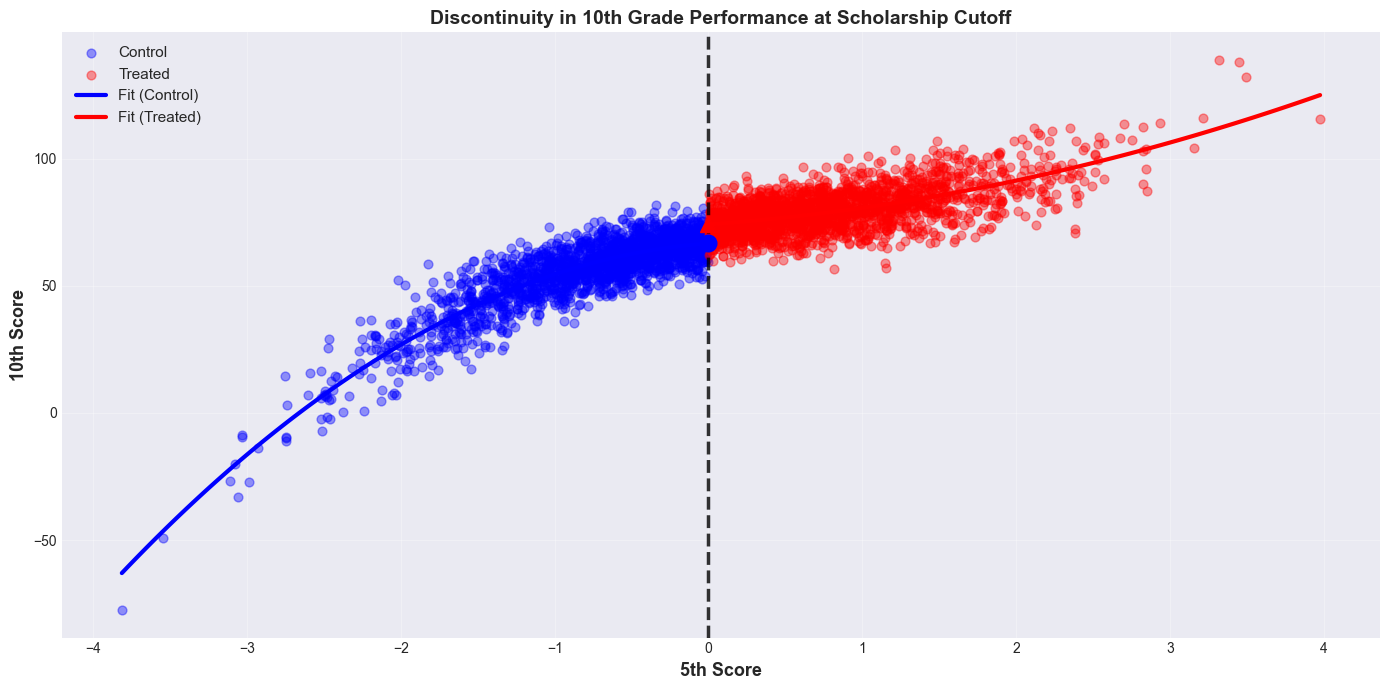

In [10]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(rdd_df[rdd_df['D']==0]['5th_score'],
          rdd_df[rdd_df['D']==0]['10th_score'],
          alpha=0.4, s=40, color='blue', label='Control')
ax.scatter(rdd_df[rdd_df['D']==1]['5th_score'],
          rdd_df[rdd_df['D']==1]['10th_score'],
          alpha=0.4, s=40, color='red', label='Treated')

x_left = rdd_df[rdd_df['5th_score'] < 0]['5th_score'].values
y_left = rdd_df[rdd_df['5th_score'] < 0]['10th_score'].values
z_left = np.polyfit(x_left, y_left, 2)
p_left = np.poly1d(z_left)
x_fit_left = np.linspace(x_left.min(), -0.01, 100)
ax.plot(x_fit_left, p_left(x_fit_left), 'b-', linewidth=3, label='Fit (Control)')

x_right = rdd_df[rdd_df['5th_score'] >= 0]['5th_score'].values
y_right = rdd_df[rdd_df['5th_score'] >= 0]['10th_score'].values
z_right = np.polyfit(x_right, y_right, 2)
p_right = np.poly1d(z_right)
x_fit_right = np.linspace(0.01, x_right.max(), 100)
ax.plot(x_fit_right, p_right(x_fit_right), 'r-', linewidth=3, label='Fit (Treated)')

ax.axvline(x=0, color='black', linestyle='--', linewidth=2.5, alpha=0.8)
predicted_left = p_left(0)
predicted_right = p_right(0)
ax.plot(0, predicted_left, 'bo', markersize=12)
ax.plot(0, predicted_right, 'r^', markersize=12)

ax.set_xlabel('5th Score', fontsize=13, fontweight='bold')
ax.set_ylabel('10th Score', fontsize=13, fontweight='bold')
ax.set_title('Discontinuity in 10th Grade Performance at Scholarship Cutoff', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Part II.d: Regression Discontinuity Estimation with Covariates

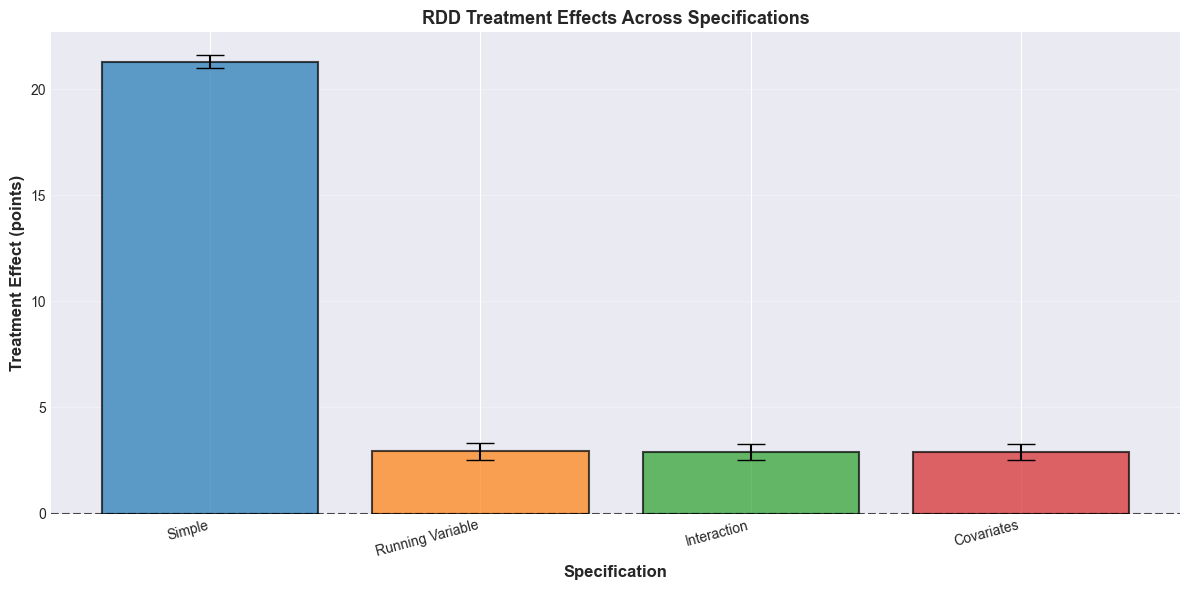


RDD Preferred Specification (With Covariates):
Treatment Effect: 2.884
Std. Error: 0.380
t-statistic: 7.580
p-value: 0.000000
95% CI: [2.138, 3.629]


In [11]:
rdd_sample = rdd_df[np.abs(rdd_df['5th_score']) <= bandwidth].copy()
rdd_sample['D_score_interaction'] = rdd_sample['D'] * rdd_sample['5th_score']

X1 = rdd_sample[['D']]
X1 = sm.add_constant(X1)
y1 = rdd_sample['10th_score']
model_rdd_simple = OLS(y1, X1).fit()

X2 = rdd_sample[['D', '5th_score']]
X2 = sm.add_constant(X2)
model_rdd_linear = OLS(y1, X2).fit()

X3 = rdd_sample[['D', '5th_score', 'D_score_interaction']]
X3 = sm.add_constant(X3)
model_rdd_interaction = OLS(y1, X3).fit()

X4 = rdd_sample[['D', '5th_score', 'D_score_interaction', 'hours_studied', 'mother_edu', 'female']]
X4 = sm.add_constant(X4)
model_rdd_covariates = OLS(y1, X4).fit()

causal_effects = {
    'Simple': model_rdd_simple.params['D'],
    'Running Variable': model_rdd_linear.params['D'],
    'Interaction': model_rdd_interaction.params['D'],
    'Covariates': model_rdd_covariates.params['D']
}

causal_ses = {
    'Simple': model_rdd_simple.bse['D'],
    'Running Variable': model_rdd_linear.bse['D'],
    'Interaction': model_rdd_interaction.bse['D'],
    'Covariates': model_rdd_covariates.bse['D']
}

fig, ax = plt.subplots(figsize=(12, 6))
models = list(causal_effects.keys())
effects = list(causal_effects.values())
errors = list(causal_ses.values())
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

ax.bar(models, effects, yerr=errors, capsize=10, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
ax.set_ylabel('Treatment Effect (points)', fontsize=12, fontweight='bold')
ax.set_xlabel('Specification', fontsize=12, fontweight='bold')
ax.set_title('RDD Treatment Effects Across Specifications', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=15, ha='right')

plt.tight_layout()
plt.savefig('results/plots/05_rdd_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nRDD Preferred Specification (With Covariates):")
print(f"Treatment Effect: {model_rdd_covariates.params['D']:.3f}")
print(f"Std. Error: {model_rdd_covariates.bse['D']:.3f}")
print(f"t-statistic: {model_rdd_covariates.tvalues['D']:.3f}")
print(f"p-value: {model_rdd_covariates.pvalues['D']:.6f}")
print(f"95% CI: [{model_rdd_covariates.params['D'] - 1.96*model_rdd_covariates.bse['D']:.3f}, {model_rdd_covariates.params['D'] + 1.96*model_rdd_covariates.bse['D']:.3f}]")